In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from scipy import stats
import os
from matplotlib.colors import ListedColormap, Normalize

In [2]:
df_bm = pd.read_csv('benchmark_nse_results_all_files.csv', index_col=0)
df_bm.index = df_bm.index.str.replace('_BM\\.csv$', '', regex=True)

border_path = '../nse_skill_score/camels-spat/politicalboundaries_shapefile/NA_PoliticalDivisions/simplified/simplified_boundaries_15km.shp'

skill_scores = pd.read_csv('../nse_skill_score/camels-spat/full_bm_skill_scores/nse_full_skill_scores.csv', index_col=0)

In [3]:
cols_to_add = ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']

# Collapse df_obs so each catchment appears once
df_obs_single = df_bm[cols_to_add].groupby(level=0).first()

# Now join safely
df_merged = skill_scores.join(df_obs_single, how='left')

# Drop rows with missing skill_score (or missing obs_seasonal_var just to be safe)
df = df_merged.dropna(subset=['skill_score', 'obs_seasonal_var']).copy()

df = df.reset_index()
df = df.rename(columns={'index': 'catchment'})

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# ============================================================================
# Helper Functions
# ============================================================================

def format_benchmark_name(benchmark_name):
    """Format benchmark names for display"""
    categories = {
        'Flow': [
            "bm_mean_flow", "bm_median_flow",
            "bm_monthly_mean_flow", "bm_monthly_median_flow",
            "bm_daily_mean_flow", "bm_daily_median_flow"
        ],
        'Rainfall': [
            "bm_rainfall_runoff_ratio_to_all",
            "bm_rainfall_runoff_ratio_to_annual",
            "bm_rainfall_runoff_ratio_to_monthly",
            "bm_rainfall_runoff_ratio_to_daily",
            "bm_rainfall_runoff_ratio_to_timestep",
            "bm_monthly_rainfall_runoff_ratio_to_monthly",
            "bm_monthly_rainfall_runoff_ratio_to_daily",
            "bm_monthly_rainfall_runoff_ratio_to_timestep"
        ],
        'Adjusted': [
            "bm_scaled_precipitation_benchmark",
            "bm_adjusted_precipitation_benchmark",
            "bm_adjusted_smoothed_precipitation_benchmark"
        ]
    }
    
    category = None
    for cat, benchmarks in categories.items():
        if benchmark_name in benchmarks:
            category = cat
            break
    
    clean_name = benchmark_name.replace('bm_', '').replace('_', ' ').title()
    if category:
        return f"{category}: {clean_name}"
    return clean_name


def get_benchmark_order():
    """Return the desired order of benchmarks for plotting"""
    return [
        "bm_mean_flow", "bm_median_flow",
        "bm_monthly_mean_flow", "bm_monthly_median_flow",
        "bm_daily_mean_flow", "bm_daily_median_flow",
        "bm_rainfall_runoff_ratio_to_all",
        "bm_rainfall_runoff_ratio_to_annual",
        "bm_rainfall_runoff_ratio_to_monthly",
        "bm_rainfall_runoff_ratio_to_daily",
        "bm_rainfall_runoff_ratio_to_timestep",
        "bm_monthly_rainfall_runoff_ratio_to_monthly",
        "bm_monthly_rainfall_runoff_ratio_to_daily",
        "bm_monthly_rainfall_runoff_ratio_to_timestep",
        "bm_scaled_precipitation_benchmark",
        "bm_adjusted_precipitation_benchmark",
        "bm_adjusted_smoothed_precipitation_benchmark"
    ]


# ============================================================================
# Analysis Functions
# ============================================================================

def analyze_variance_benchmark_correlation(df, period='all'):
    """
    Analyze correlation between benchmark skill scores and variance components
    """
    df_filtered = df[df['period'] == period].copy() if period else df.copy()
    benchmarks = df_filtered['benchmark'].unique()
    var_components = ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']
    
    results = []
    for benchmark in benchmarks:
        bm_data = df_filtered[df_filtered['benchmark'] == benchmark]
        
        for var_comp in var_components:
            spearman_r, spearman_p = stats.spearmanr(bm_data['skill_score'], 
                                                      bm_data[var_comp])
            
            results.append({
                'benchmark': benchmark,
                'variance_component': var_comp,
                'spearman_r': spearman_r,
                'spearman_p': spearman_p,
                'n_catchments': len(bm_data)
            })
    
    results_df = pd.DataFrame(results)
    results_df['spearman_sig'] = results_df['spearman_p'] < 0.05
    
    return results_df


def categorize_catchments(df):
    """Categorize catchments by dominant variance component"""
    df_cat = df.copy()
    
    catchment_variance = df_cat.groupby('catchment')[
        ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']
    ].first()
    
    catchment_variance['dominant_variance'] = catchment_variance.idxmax(axis=1)
    catchment_variance['dominant_variance'] = catchment_variance['dominant_variance'].str.replace('obs_', '').str.replace('_var', '')
    
    df_cat = df_cat.merge(
        catchment_variance[['dominant_variance']], 
        left_on='catchment', 
        right_index=True
    )
    
    return df_cat


def best_benchmarks_by_variance_profile(df, period='all', top_n=5):
    """Find which benchmarks perform best for each variance profile"""
    df_filtered = df[df['period'] == period].copy() if period else df.copy()
    df_cat = categorize_catchments(df_filtered)
    
    results = {}
    
    for var_type in ['seasonal', 'interannual', 'irregular']:
        subset = df_cat[df_cat['dominant_variance'] == var_type]
        avg_scores = subset.groupby('benchmark')['skill_score'].agg(['mean', 'std', 'count'])
        avg_scores = avg_scores.sort_values('mean', ascending=False)
        results[var_type] = avg_scores.head(top_n)
    
    return results


def analyze_rank_stability(df, period='all'):
    """Analyze how benchmark ranks change across variance profiles"""
    df_filtered = df[df['period'] == period].copy() if period else df.copy()
    
    # Categorize catchments by dominant variance
    catchment_variance = df_filtered.groupby('catchment')[
        ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']
    ].first()
    
    catchment_variance['dominant_variance'] = catchment_variance.idxmax(axis=1)
    catchment_variance['dominant_variance'] = catchment_variance['dominant_variance'].str.replace('obs_', '').str.replace('_var', '')
    
    # Rank benchmarks within each catchment (1 = best)
    df_filtered['rank'] = df_filtered.groupby('catchment')['skill_score'].rank(
        ascending=False, method='average'
    )
    
    # Merge dominant variance back
    df_filtered = df_filtered.merge(
        catchment_variance[['dominant_variance']], 
        left_on='catchment', 
        right_index=True
    )
    
    # Calculate average rank by benchmark and variance type
    rank_summary = df_filtered.groupby(['benchmark', 'dominant_variance']).agg({
        'rank': ['mean', 'std'],
        'skill_score': ['mean', 'std'],
        'catchment': 'nunique'
    }).reset_index()
    
    rank_summary.columns = ['benchmark', 'variance_type', 'avg_rank', 'std_rank', 
                            'avg_score', 'std_score', 'n_catchments']
    
    return rank_summary


# ============================================================================
# Visualization Functions
# ============================================================================

def plot_dominant_variance_map(df, skill_scores_df, border_path=None):
    """
    Plot a map showing dominant variance type at each catchment location
    
    Parameters:
    -----------
    df : DataFrame with variance components (used to determine dominant variance)
    skill_scores_df : DataFrame with lat/lon columns
    border_path : path to shapefile for background borders
    """
    import geopandas as gpd
    
    # Categorize catchments by dominant variance
    catchment_variance = df.groupby('catchment')[
        ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']
    ].first()
    
    catchment_variance['dominant_variance'] = catchment_variance.idxmax(axis=1)
    catchment_variance['dominant_variance'] = catchment_variance['dominant_variance'].str.replace('obs_', '').str.replace('_var', '')
    
    # Get unique catchment locations from skill_scores_df
    catchment_locs = skill_scores_df.groupby('catchment')[['latitude', 'longitude']].first()
    
    # Merge with dominant variance
    plot_data = catchment_locs.join(catchment_variance['dominant_variance'])
    plot_data = plot_data.reset_index()
    
    # Define colors for each variance type
    colors = {
        'seasonal': '#E69F00',      # Orange
        'interannual': '#56B4E9',   # Light blue
        'irregular': '#CC79A7'      # Pink/purple
    }
    
    # Calculate extent with buffer
    lon_min = plot_data['longitude'].min() - 3
    lon_max = plot_data['longitude'].max() + 3
    lat_min = plot_data['latitude'].min() - 3
    lat_max = plot_data['latitude'].max() + 3
    
    # Create figure - use consistent sizing like your reference
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Load and plot borders if available
    if border_path and os.path.exists(border_path):
        gdf_borders = gpd.read_file(border_path)
        
        # Reproject to EPSG:4326 if needed
        if gdf_borders.crs != "EPSG:4326":
            gdf_borders = gdf_borders.to_crs("EPSG:4326")
        
        # Trim borders to extent
        gdf_trim = gdf_borders[
            (gdf_borders.geometry.bounds.minx <= lon_max) &
            (gdf_borders.geometry.bounds.maxx >= lon_min) &
            (gdf_borders.geometry.bounds.miny <= lat_max) &
            (gdf_borders.geometry.bounds.maxy >= lat_min)
        ]
        
        # Plot borders with light gray fill
        gdf_trim.plot(ax=ax, facecolor='#f0f0f0', edgecolor='grey', linewidth=0.8)
    
    # Set extent
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    
    # Plot catchments colored by dominant variance
    for var_type in ['seasonal', 'interannual', 'irregular']:
        data = plot_data[plot_data['dominant_variance'] == var_type]
        ax.scatter(data['longitude'], data['latitude'], 
                  c=colors[var_type], s=50, alpha=0.8, 
                  edgecolors='k', linewidth=0.5,
                  label=var_type.capitalize(), zorder=3)
    
    # Format axes - cleaner style
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.tick_params(labelsize=11)
    
    # No gridlines for cleaner look
    ax.grid(False)
    
    # Add legend to the upper right with box
    legend = ax.legend(title='Dominant Variance', loc='upper right',
                      frameon=True, framealpha=1.0, fontsize=11, 
                      title_fontsize=12, edgecolor='black', 
                      fancybox=False, shadow=False)
    legend.get_frame().set_linewidth(1.0)
    
    # Add counts to legend
    for var_type, text in zip(['seasonal', 'interannual', 'irregular'], legend.get_texts()):
        count = len(plot_data[plot_data['dominant_variance'] == var_type])
        text.set_text(f'{text.get_text()} (n={count})')
    
    # Box around plot
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.0)
        spine.set_edgecolor('black')
    
    plt.tight_layout()
    
    return fig


def plot_combined_heatmap_analysis(results_df, rank_summary):
    """
    Create combined 3-panel heatmap showing correlations, scores, and ranks
    """
    
    # Prepare correlation data
    pivot_r = results_df.pivot(index='benchmark', 
                                columns='variance_component', 
                                values='spearman_r')
    pivot_p = results_df.pivot(index='benchmark', 
                                columns='variance_component', 
                                values='spearman_p')
    
    column_order = ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']
    pivot_r = pivot_r[column_order]
    pivot_p = pivot_p[column_order]
    pivot_r.columns = ['Seasonal', 'Interannual', 'Irregular']
    pivot_p.columns = ['Seasonal', 'Interannual', 'Irregular']
    
    # Prepare score data
    pivot_score = rank_summary.pivot(index='benchmark', 
                                      columns='variance_type', 
                                      values='avg_score')
    pivot_score = pivot_score[['seasonal', 'interannual', 'irregular']]
    pivot_score.columns = ['Seasonal', 'Interannual', 'Irregular']
    
    # Prepare rank data
    pivot_rank = rank_summary.pivot(index='benchmark', 
                                     columns='variance_type', 
                                     values='avg_rank')
    pivot_rank = pivot_rank[['seasonal', 'interannual', 'irregular']]
    pivot_rank.columns = ['Seasonal', 'Interannual', 'Irregular']
    
    # Reorder rows by category
    benchmark_order = get_benchmark_order()
    benchmark_order = [b for b in benchmark_order if b in pivot_r.index]
    
    pivot_r = pivot_r.loc[benchmark_order]
    pivot_p = pivot_p.loc[benchmark_order]
    pivot_score = pivot_score.loc[benchmark_order]
    pivot_rank = pivot_rank.loc[benchmark_order]
    
    # Format benchmark names with line breaks for long names
    def format_with_linebreaks(name):
        formatted = format_benchmark_name(name)
        # Add line break if name is too long (>35 characters)
        if len(formatted) > 35:
            # Try to break at a natural point (space)
            words = formatted.split()
            mid = len(words) // 2
            formatted = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
        return formatted
    
    formatted_names = [format_with_linebreaks(b) for b in benchmark_order]
    
    # Create figure with 3 subplots - more spacing
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(1, 3, width_ratios=[1.5, 1, 1], wspace=0.2)
    
    axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
    
    # Panel 1: Spearman Correlations
    ax = axes[0]
    sns.heatmap(pivot_r, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                vmin=-1, vmax=1, 
                cbar_kws={'label': 'Spearman ρ', 'shrink': 0.7},
                ax=ax, linewidths=0.5, annot_kws={'fontsize': 10},
                yticklabels=formatted_names)
    
    # Add significance markers
    for i in range(len(pivot_r.index)):
        for j, var_comp in enumerate(pivot_r.columns):
            p_val = pivot_p.iloc[i, j]
            if p_val < 0.001:
                ax.text(j + 0.5, i + 0.15, '***', ha='center', va='center', 
                       fontsize=8, color='black', weight='bold')
            elif p_val < 0.01:
                ax.text(j + 0.5, i + 0.15, '**', ha='center', va='center', 
                       fontsize=8, color='black', weight='bold')
            elif p_val < 0.05:
                ax.text(j + 0.5, i + 0.15, '*', ha='center', va='center', 
                       fontsize=8, color='black', weight='bold')
    
    # Add category separators
    category_breaks = [6, 14, 17]
    for break_point in category_breaks:
        if break_point < len(pivot_r):
            ax.axhline(break_point, color='black', linewidth=2)
    
    ax.set_xlabel('Variance Component', fontsize=10, weight='bold')
    ax.set_ylabel('')
    ax.set_title('(a) Correlation', fontsize=11, pad=10)
    # Add significance note as separate text
    ax.text(0.5, 1.08, '(*p<0.05  **p<0.01  ***p<0.001)', 
            transform=ax.transAxes, ha='center', fontsize=9, style='italic')
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='x', rotation=45)
    
    # Panel 2: Mean Skill Scores
    ax = axes[1]
    sns.heatmap(pivot_score, annot=True, fmt='.2f', cmap='YlGnBu',
                vmin=0, vmax=1, 
                cbar_kws={'label': 'Mean KGE', 'shrink': 0.7},
                ax=ax, linewidths=0.5, annot_kws={'fontsize': 10},
                yticklabels=False)
    
    for break_point in category_breaks:
        if break_point < len(pivot_score):
            ax.axhline(break_point, color='black', linewidth=2)
    
    ax.set_xlabel('Dominant Variance', fontsize=10, weight='bold')
    ax.set_ylabel('')
    ax.set_title('(b) Mean Score', fontsize=11, pad=10)
    ax.tick_params(axis='x', rotation=45)
    
    # Panel 3: Mean Ranks
    ax = axes[2]
    sns.heatmap(pivot_rank, annot=True, fmt='.1f', cmap='RdYlGn_r',
                vmin=1, vmax=17, 
                cbar_kws={'label': 'Mean Rank', 'shrink': 0.7},
                ax=ax, linewidths=0.5, annot_kws={'fontsize': 10},
                yticklabels=False)
    
    for break_point in category_breaks:
        if break_point < len(pivot_rank):
            ax.axhline(break_point, color='black', linewidth=2)
    
    ax.set_xlabel('Dominant Variance', fontsize=10, weight='bold')
    ax.set_ylabel('')
    ax.set_title('(c) Mean Rank', fontsize=11, pad=10)
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    return fig


# ============================================================================

In [5]:
# 1. Get correlation results
results = analyze_variance_benchmark_correlation(df, period='validation')


In [6]:
# 2. Get rank summary
rank_summary = analyze_rank_stability(df, period='validation')

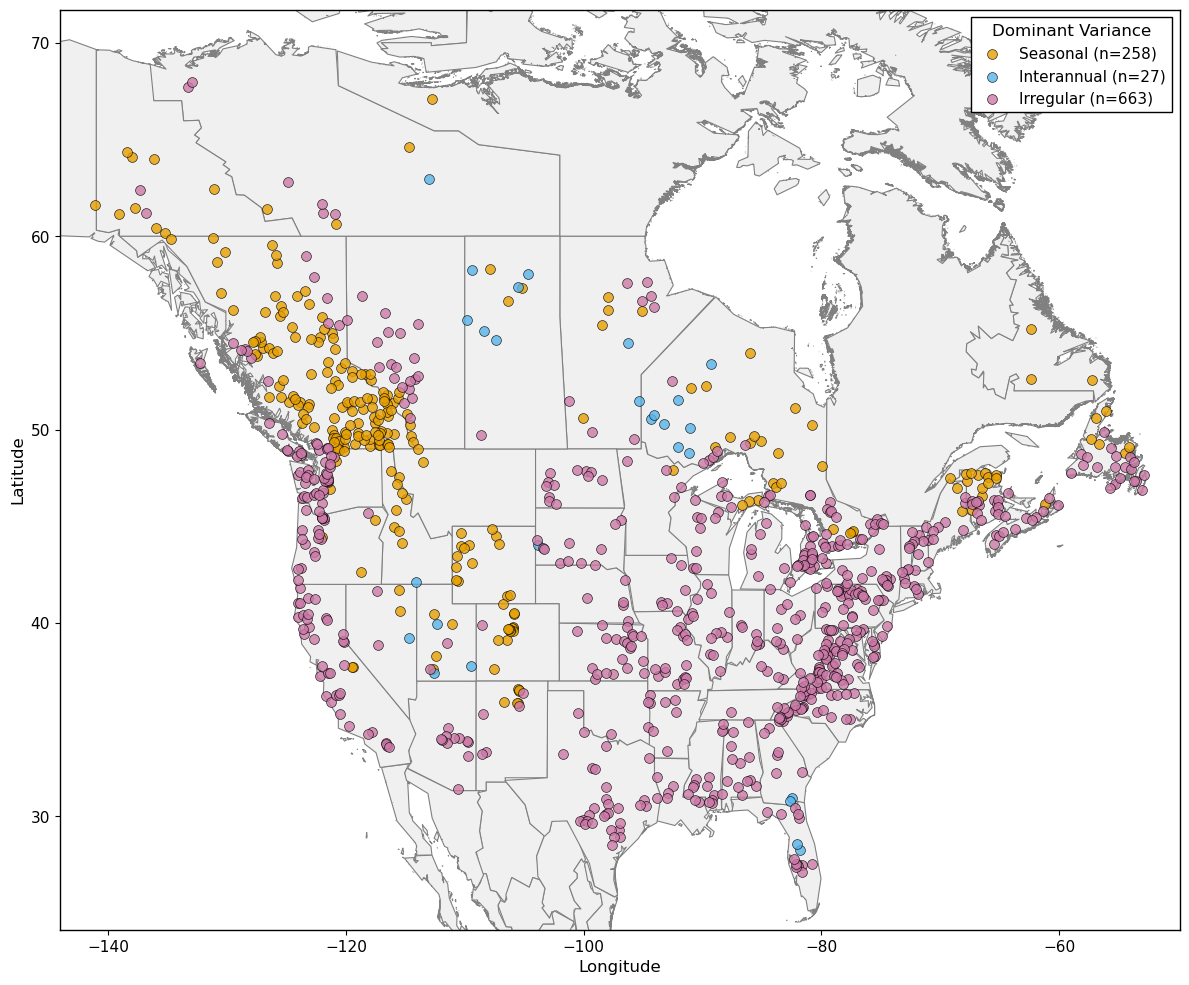

In [7]:
fig = plot_dominant_variance_map(df, skill_scores, border_path=border_path)
plt.savefig('dominant_variance_map.pdf', dpi=300, bbox_inches='tight')
plt.savefig('dominant_variance_map.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_189126/767353700.py:417: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


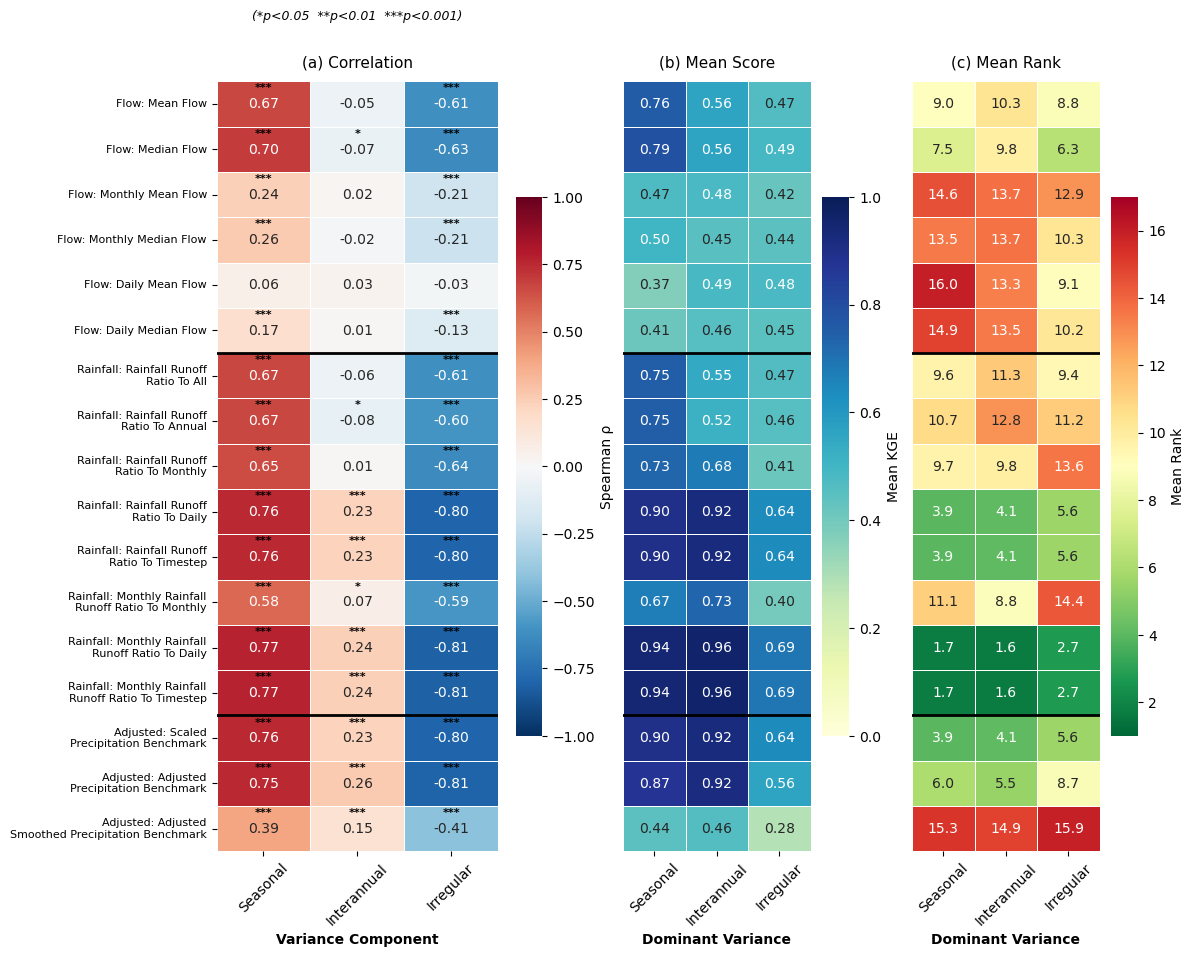

In [8]:
# 3. Create combined heatmap
fig = plot_combined_heatmap_analysis(results, rank_summary)
plt.savefig('combined_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.savefig('combined_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# 4. Optional: Print best benchmarks
best_bms = best_benchmarks_by_variance_profile(df, period='all', top_n=17)
for var_type, scores in best_bms.items():
    print(f"\n{var_type.upper()} variance:")
    print(scores)


SEASONAL variance:
                                                  mean       std  count
benchmark                                                              
bm_monthly_rainfall_runoff_ratio_to_daily     0.947628  0.202941    258
bm_monthly_rainfall_runoff_ratio_to_timestep  0.947628  0.202941    258
bm_rainfall_runoff_ratio_to_timestep          0.910334  0.432717    258
bm_rainfall_runoff_ratio_to_daily             0.910334  0.432717    258
bm_scaled_precipitation_benchmark             0.910334  0.432717    258
bm_adjusted_precipitation_benchmark           0.889386  0.541649    258
bm_median_flow                                0.811757  0.555660    258
bm_mean_flow                                  0.782576  0.635902    258
bm_rainfall_runoff_ratio_to_all               0.781711  0.636283    258
bm_rainfall_runoff_ratio_to_annual            0.777495  0.640955    258
bm_rainfall_runoff_ratio_to_monthly           0.765109  0.804490    258
bm_monthly_rainfall_runoff_ratio_to_monthly 